# Simple Corridor - Default


This is a simple environment where agents start at the left end target is at the other end.

In [1]:
import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.dqn import DQNTrainer

import pygame
import numpy as np

import torch
from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import time

pygame 2.1.2 (SDL 2.0.16, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SimpleCorridor(gym.Env):
    def __init__(self, config):
        self.length = config["corridor_length"]
        self.mode = config["mode"] # "fixed" or "random"
        
        if self.mode == "fixed":
            self.start_pos = 0
            self.end_pos = self.length-1
        elif self.mode == "random":
            self.start_pos, self.end_pos = random.sample(range(self.length),2)
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(0.0, self.length, shape=(2,),dtype='int32')

    def reset(self):
        self.cur_pos = self.start_pos
        return np.array([self.cur_pos, self.end_pos])

    def step(self, action):
        if action == 0 and self.cur_pos > 0: # walk left
            self.cur_pos -= 1
        if action == 1 and self.cur_pos < self.length-1:
            self.cur_pos += 1
        done = self.cur_pos == self.end_pos
        reward = 1.0 if done else -0.1
        return np.array([self.cur_pos, self.end_pos]), reward, done, {} 
    def render(self, mode="rgb_array"):
        canvas = pygame.Surface((20, 20*self.length+1))
        canvas.fill((255, 255, 255))
        for i in range(self.length+2):
            pygame.draw.line(canvas, 0, (0, 20*(i)), (20, 20*(i)), width=1)
        pygame.draw.line(canvas, 0, (0,0), (0, 20*(i)), width=1)
        pygame.draw.line(canvas, 0, (19,0), (19, 20*(i)), width=1)
        pygame.draw.circle(canvas, (0, 0, 255), (10,self.cur_pos*20+10), 7)
        pygame.draw.circle(canvas, (255, 0, 0), (10,(self.end_pos)*20+10), 7)
        plArray = np.array(pygame.surfarray.pixels3d(canvas))
        plt.imshow(plArray)        
        plt.axis("off")

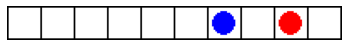

In [3]:
env = SimpleCorridor({"corridor_length": 10, "mode":"random"})
env.reset()
env.render()

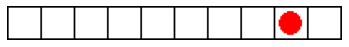

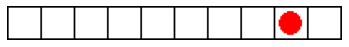

In [4]:
env.reset()
done = False

while not done:
    plt.cla()
    display.clear_output(wait=True)

    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.01)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.gcf()

In [ ]:
trainer = PPOTrainer(
    config={
        "env": SimpleCorridor,
        "framework": "torch",
        "env_config": {
            "corridor_length": 10,
            "mode":"random"
        },
        "num_workers": 4,
        
            "model": {
            "fcnet_hiddens": [64, 64],
            "fcnet_activation": "relu",
        },
    },
)

In [ ]:
for i in range(20):
    
    results = trainer.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")


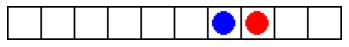

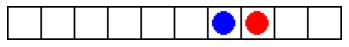

In [7]:
for _ in range(20):

    env = SimpleCorridor({"corridor_length": 10, "mode":"random"})
    # Get the initial observation (should be: [0.0] for the starting position).
    obs = env.reset()
    done = False
    total_reward = 0.0
    # Play one episode.
    while not done:
        plt.cla()
        env.render()

        action = trainer.compute_single_action(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        time.sleep(0.1)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.gcf()


## How to save and load the model

In [8]:
# save
#trainer.save("dir")

In [9]:
# load
trainer.load_checkpoint("checkpoint_000020/checkpoint-20")

## How to use use tensorboard to view the training history

In [ ]:
# Plugging in Ray Tune.
# Note that this is the recommended way to run any experiments with RLlib.
# Reasons:
# - Tune allows you to do hyperparameter tuning in a user-friendly way
#   and at large scale!
# - Tune automatically allocates needed resources for the different
#   hyperparam trials and experiment runs on a cluster.

from ray import tune
tune_config = {
        "env": SimpleCorridor,
        "framework": "torch",
        "env_config": {
            "corridor_length": 10,
            "mode":"random"
        },
        "num_workers": 4,
        
            "model": {
            "fcnet_hiddens": [64, 64],
            "fcnet_activation": "relu",
        },
}

stop = {
    # Note that the keys used here can be anything present in the above `rllib_trainer.train()` output dict.
    "training_iteration": 20,
    "episode_reward_mean": 1.,
}

tune.run(
    "PPO",
    config=tune_config,
    stop=stop,
    local_dir="log_dir",
    checkpoint_at_end=True,  # ... create a checkpoint when done.
    checkpoint_freq=10,  # ... create a checkpoint every 10 training iterations.
    
)

In [ ]:
trainer = PPOTrainer(config=tune_config) 

In [11]:
trainer.restore("log_dir/PPO/PPO_SimpleCorridor_641b4_00000_0_2022-07-07_11-18-13/checkpoint_000020/checkpoint-20")

2022-07-07 11:26:28,937	INFO trainable.py:588 -- Restored on 10.13.62.8 from checkpoint: log_dir/PPO/PPO_SimpleCorridor_641b4_00000_0_2022-07-07_11-18-13/checkpoint_000020/checkpoint-20
2022-07-07 11:26:28,939	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 65.94189524650574, '_episodes_total': 22613}


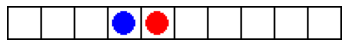

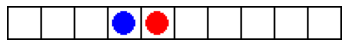

In [12]:
for _ in range(20):

    env = SimpleCorridor({"corridor_length": 10, "mode":"random"})
    # Get the initial observation (should be: [0.0] for the starting position).
    obs = env.reset()
    done = False
    total_reward = 0.0
    # Play one episode.
    while not done:
        plt.cla()
        env.render()

        action = trainer.compute_single_action(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        time.sleep(0.1)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.gcf()